<span style="font-width:bold; font-size: 3rem; color:#333;">- Batch Inference</span>

In [1]:
import sys
from pathlib import Path

#Find root directory
root_dir = Path().absolute()
if root_dir.parts[-2:] == ('notebooks', 'algae_bloom'):
    root_dir = Path(*root_dir.parts[:-2])
root_dir = str(root_dir)

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Root dir: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-project
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-project


## 🌐 Imports

In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 12, 19, 13, 35, 53, 640940)

## 🌳 Connect to Hopsworks and get variables from Hopsworks secret </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

#Get the dictionary with all batch locations
bath_locations_json = secrets.get_secret("BATH_LOCATIONS_JSON").value
bath_locations = json.loads(bath_locations_json)
print(bath_locations)

2025-12-19 13:35:58,201 INFO: Initializing external client
2025-12-19 13:35:58,202 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-12-19 13:35:58,885 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-12-19 13:36:00,111 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286295
[{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}, {'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}, {'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}, {'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}, {'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}, {'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}, {'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}, {'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}, {'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}]


## ⚓︎ Download model from model registry

In [6]:
mr = project.get_model_registry()

#Retrieve model from Hopsworks
model_version = 1

retrieved_model = mr.get_model(
    name="water_temperature_xgboost_model", 
    version=model_version, 
)
fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-12-19 13:38:02,234 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/552757 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/33705 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/70326 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/44759 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/67168 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/37737 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62995 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122505 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/130739 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26824 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28651 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0373552E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## ☔️ Get the weather forecast features from the feature view



In [ ]:
#Select version of feature group
w_version = 1

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.formatted_time >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 


,formatted_time,alias,rounded,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,latitude,longitude
1195,2022-01-04 11:35:00+00:00,Åbynäsbadet,2022-01-04 12:00:00+00:00,0.9280,0.0,15.188416,238.570480,59.018397,17.619576
5133,2022-01-04 11:36:00+00:00,Eklundsnäsbadet,2022-01-04 12:00:00+00:00,1.2735,0.0,17.673029,236.633606,59.168830,17.591840
6934,2022-01-04 11:37:00+00:00,Nya Malmsjöbadet,2022-01-04 12:00:00+00:00,1.2330,0.0,20.969807,235.491425,59.234823,17.536534
6789,2022-01-04 11:40:00+00:00,Farstanäsbadet,2022-01-04 12:00:00+00:00,1.0600,0.0,15.683774,238.134064,59.096884,17.653870
3362,2022-01-04 11:44:00+00:00,Underåsbadet,2022-01-04 12:00:00+00:00,1.5125,0.0,18.775303,237.528824,59.264820,17.536534
...,...,...,...,...,...,...,...,...,...
4245,2025-12-12 13:36:00+00:00,Mälarbadet,2025-12-12 14:00:00+00:00,3.0470,0.0,10.429132,68.749428,59.222657,17.611886
3159,2025-12-13 13:36:00+00:00,Mälarbadet,2025-12-13 14:00:00+00:00,4.5970,0.5,9.444426,187.666718,59.222657,17.611886
2540,2025-12-14 13:36:00+00:00,Mälarbadet,2025-12-14 14:00:00+00:00,6.7470,0.2,20.675724,229.236481,59.222657,17.611886
332,2025-12-15 13:36:00+00:00,Mälarbadet,2025-12-15 14:00:00+00:00,7.6970,0.0,18.679283,237.994659,59.222657,17.611886


## 🔮 Add lagging features for comming days using predictions  </span>


In [ ]:
#Select version of feature group
wt_version = 1

water_temperature_fg = fs.get_feature_group(
    name='water_temperature',
    version=wt_version,
)
batch_data = batch_data.sort_values("formatted_time")

batch_data_frames = []
for location_dict in bath_locations:
    bath_location = location_dict['bath_location']

    wt_df = water_temperature_fg.filter(water_temperature_fg.alias == bath_location)
    aq_df = water_temperature_fg.read()
    aq_df = aq_df[aq_df['street'] == street]
    aq_df = aq_df.sort_values("date")[-3:]

    temp_batch_data = batch_data.copy()

    for i in range (batch_data.shape[0]):
        if i == 0:
            lagged1_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
            lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged1_df.empty:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==1:
            temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
            
            lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==2:
            temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
            temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
            
            lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
            
        else:
            temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
            temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
            temp_batch_data.loc[i, "lagged_aq_3_days"] = temp_batch_data.iloc[i-3]['predicted_pm25']

        temp_batch_data['lagged_aq_1_day'] = temp_batch_data['lagged_aq_1_day'].astype(float)
        temp_batch_data['lagged_aq_2_days'] = temp_batch_data['lagged_aq_2_days'].astype(float)
        temp_batch_data['lagged_aq_3_days'] = temp_batch_data['lagged_aq_3_days'].astype(float)
        temp_batch_data.loc[i,'predicted_pm25'] = models[street].predict(
        temp_batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])[i]
    print(temp_batch_data)
    batch_data_frames.append(temp_batch_data)
    
#batch_data_frames[1]


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.91s) 
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.35   
1 2025-11-20 00:00:00+00:00                         3.30   
2 2025-11-21 00:00:00+00:00                         2.35   
3 2025-11-22 00:00:00+00:00                         7.10   
4 2025-11-23 00:00:00+00:00                         5.65   
5 2025-11-24 00:00:00+00:00                         4.95   

   weather_precipitation_sum  weather_wind_speed_10m_max  \
0                        0.0                   17.339897   
1                        0.0                   17.317459   
2                        0.0                   10.195057   
3                        0.0                   14.982228   
4                        0.0                    5.351785   
5                        0.0                   11.525623   

   weather_wind_direction_10m_dominant       city  lagged_aq_1_day  \
0 

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
if running_e:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    batch_data

In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
dtypes: datetime64[us, Etc/UTC](1), float32(4), object(1)
memory usage: 320.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:

if running_e or running_c:
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

if running_a:
    k=0
    for batch_df in batch_data_frames:
        print(locations[k])
        batch_df['street'] = locations[k]['street']
        batch_df['city'] = city
        batch_df['country'] = country
        # Fill in the number of days before the date on which you made the forecast (base_date)
        batch_df = batch_df.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
        batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
        batch_data_frames[k] = batch_df
        
        k+=1

#batch_data_frames[5]

{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'tower street', 'aqicn_url': 'https://api.waqi.info/feed/@11656/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'salamander st', 'aqicn_url': 'https://api.waqi.info/feed/@5986/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'st leonards', 'aqicn_url': 'https://api.waqi.info/feed/@5987/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'balmwell terrace', 'aqicn_url': 'https://api.waqi.info/feed/A93199/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': "st john's road", 'aqicn_url': 'https://api.waqi.info/feed/@9580/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'queensferry road', 'aqicn_url': 'https:/

In [13]:
if running_a:   
    batch_data_frames[5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
 6   lagged_aq_1_day                      6 non-null      float64                
 7   lagged_aq_2_days                     6 non-null      float64                
 8   lagged_aq_3_days                     6 non-null      float64              

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 18:38:38,501 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



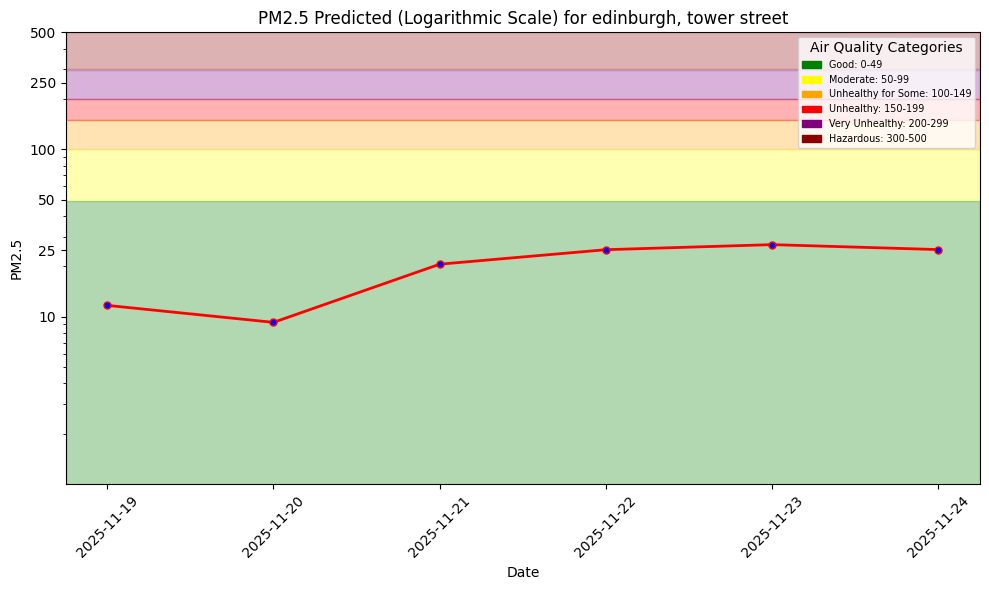

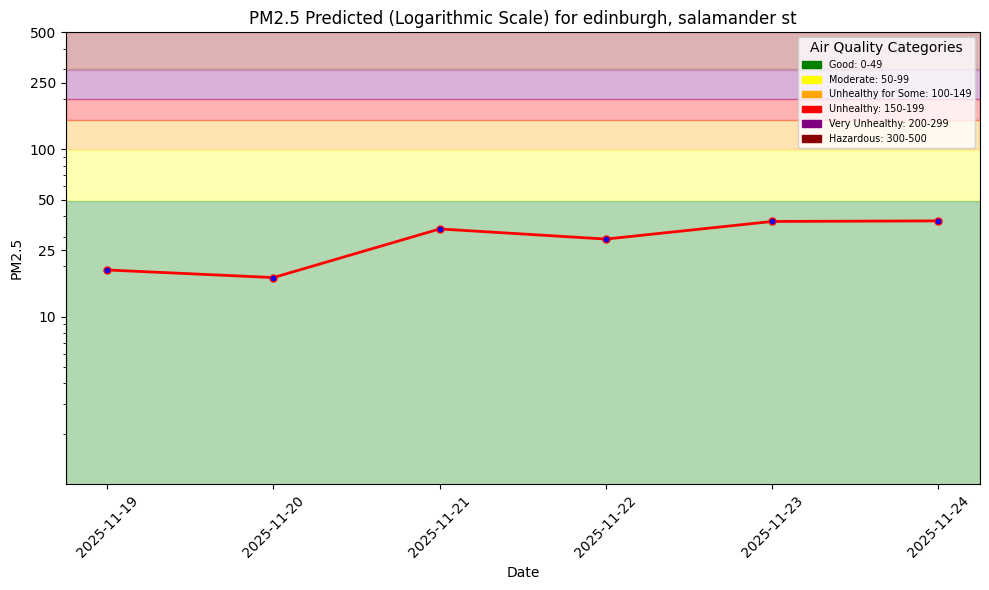

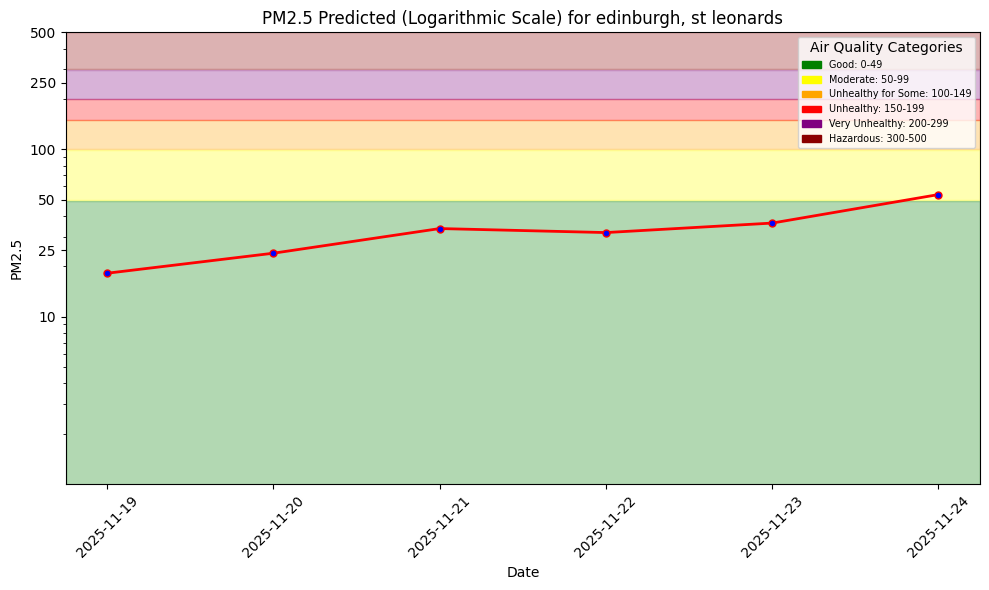

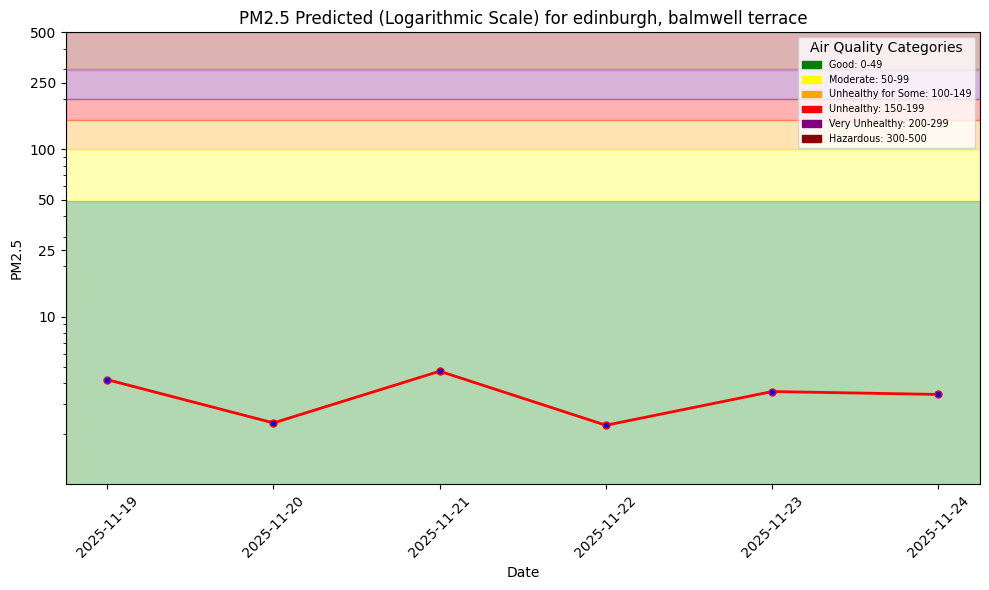

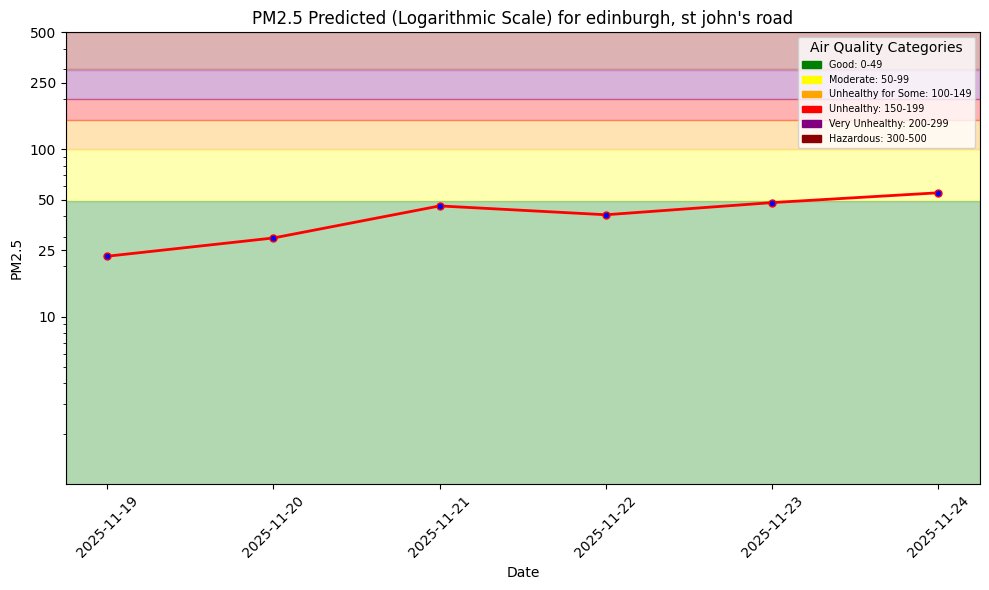

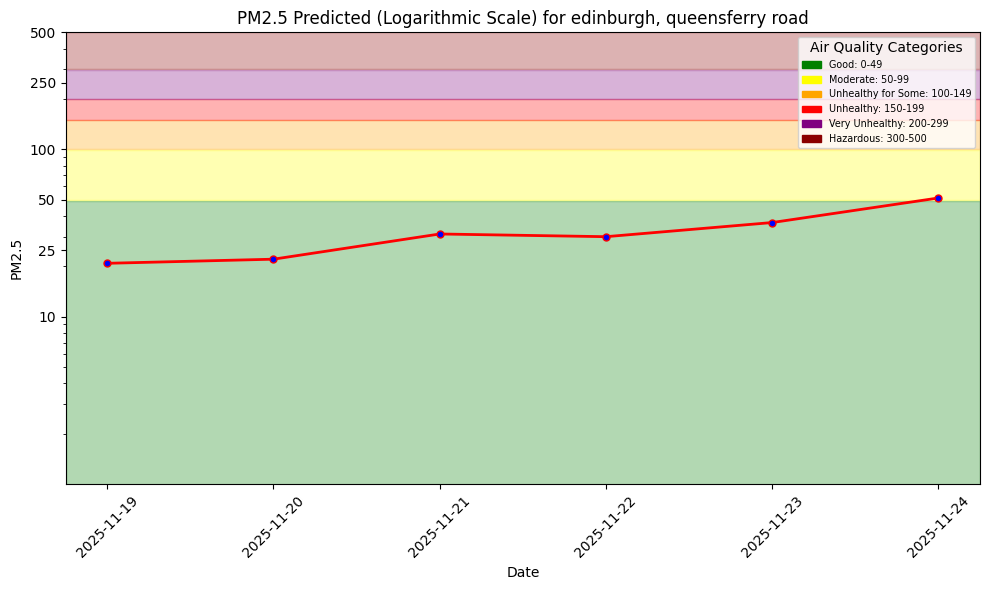

In [14]:
if running_e or running_c:
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

    plt.show()

if running_a:
    for batch_df in batch_data_frames:
        street = batch_df['street'][0]
        pred_file_path = f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_forecast{street}.png"
        plt = util.plot_air_quality_forecast(city, street, batch_df, pred_file_path)

        plt.show()

In [15]:
# Get or create feature group

#Select version of feature group
if running_e:
    m_version = 1

if running_c:
    m_version = 2

if running_a:
    m_version = 3

monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=m_version,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
if running_e or running_c:
    monitor_fg.insert(batch_data, wait=True)

if running_a:
    all_data_frames = None
    for frame in batch_data_frames:
        if all_data_frames is None:
            all_data_frames = frame
        else:
            all_data_frames = pd.concat([all_data_frames,frame], ignore_index=True)
    monitor_fg.insert(all_data_frames, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 36/36 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 18:39:16,661 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 18:39:19,942 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 18:39:23,252 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:40:54,070 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 18:40:54,315 INFO: Waiting for log aggregation to finish.
2025-11-18 18:41:02,991 INFO: Execution finished successfully.


In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,22.0,21.0,26.0,12.548160,tower street,united-kingdom,1
1,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,21.0,20.0,22.0,13.095717,salamander st,united-kingdom,1
2,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,19.0,19.0,21.0,19.842331,st leonards,united-kingdom,1
3,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,4.0,6.0,7.0,26.200932,balmwell terrace,united-kingdom,1
4,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.0,20.0,22.0,18.295746,st john's road,united-kingdom,1
5,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.0,17.0,20.0,22.494715,queensferry road,united-kingdom,1
6,2025-11-19 00:00:00+00:00,2.35,0.0,17.339897,311.633453,edinburgh,10.0,22.0,21.0,11.685105,tower street,united-kingdom,1
7,2025-11-19 00:00:00+00:00,2.35,0.0,17.339897,311.633453,edinburgh,9.0,21.0,20.0,19.017040,salamander st,united-kingdom,1
8,2025-11-19 00:00:00+00:00,2.35,0.0,17.339897,311.633453,edinburgh,10.0,19.0,19.0,18.187780,st leonards,united-kingdom,1
9,2025-11-19 00:00:00+00:00,2.35,0.0,17.339897,311.633453,edinburgh,6.0,4.0,6.0,4.205891,balmwell terrace,united-kingdom,1


In [18]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3
    
air_quality_fg = fs.get_feature_group(name='air_quality', version=aq_version)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,date,pm25,country,city,street,url,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days
0,2024-01-14 00:00:00+00:00,9.00,united-kingdom,edinburgh,tower street,https://api.waqi.info/feed/@11656/,12.0,16.00,9.00
1,2024-04-02 00:00:00+00:00,10.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,22.0,24.00,12.00
2,2023-04-09 00:00:00+00:00,47.00,united-kingdom,edinburgh,queensferry road,https://api.waqi.info/feed/@5985/,40.0,21.00,13.00
3,2022-12-20 00:00:00+00:00,24.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,9.0,31.00,17.00
4,2021-09-01 00:00:00+00:00,3.97,united-kingdom,edinburgh,balmwell terrace,https://api.waqi.info/feed/A93199/,2.5,2.04,1.08
...,...,...,...,...,...,...,...,...,...
17082,2025-11-18 00:00:00+00:00,11.00,united-kingdom,edinburgh,queensferry road,https://api.waqi.info/feed/@5985/,18.0,17.00,20.00
17083,2025-11-18 00:00:00+00:00,9.00,united-kingdom,edinburgh,salamander st,https://api.waqi.info/feed/@5986/,21.0,20.00,22.00
17084,2025-11-18 00:00:00+00:00,10.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,19.0,19.00,21.00
17085,2025-11-18 00:00:00+00:00,11.00,united-kingdom,edinburgh,st john's road,https://api.waqi.info/feed/@9580/,18.0,20.00,22.00


In [19]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    all_features_df = pd.merge(air_quality_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days', 'date']], features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'date', 'city']])
    all_features_df = all_features_df.sort_values(by=['date'], ascending=True)
    all_features_df = all_features_df.tail(10)

    if running_c:
    
        all_features_df['predicted_pm25'] = model.predict(all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])
        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    if running_a:
        street = air_quality_df.iloc[0]['street']
        all_features_df.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

        all_features_df['predicted_pm25'] = model[street].predict(
            all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])

        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    return hindcast_df
    



In [20]:


if running_e or running_c:
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df

if running_a:
    outcome_df = air_quality_df[['date', 'pm25', 'street']]
    preds_df =  monitoring_df[['date', 'predicted_pm25', 'street']]

    hindcast_df = pd.merge(preds_df, outcome_df, on=['date', 'street'])    
    
    hindcast_dfs = []
    for location in locations:
        sensor_hindcast_df = hindcast_df[hindcast_df['street'] == location['street']]
        sensor_aq_df = air_quality_df[air_quality_df['street'] == location['street']]
        
        sensor_hindcast_df = sensor_hindcast_df.sort_values(by=['date'])

        # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
        if len(sensor_hindcast_df) == 0:
            sensor_hindcast_df = backfill_predictions_for_monitoring(weather_fg, sensor_aq_df, monitor_fg, models)
        
        hindcast_dfs.append(sensor_hindcast_df)

#hindcast_dfs[1]

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

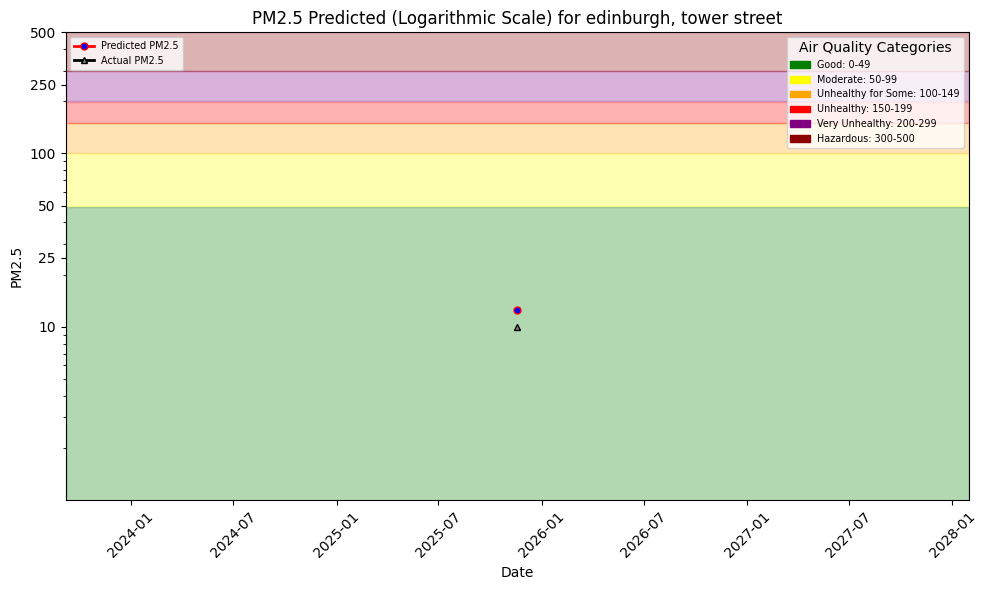

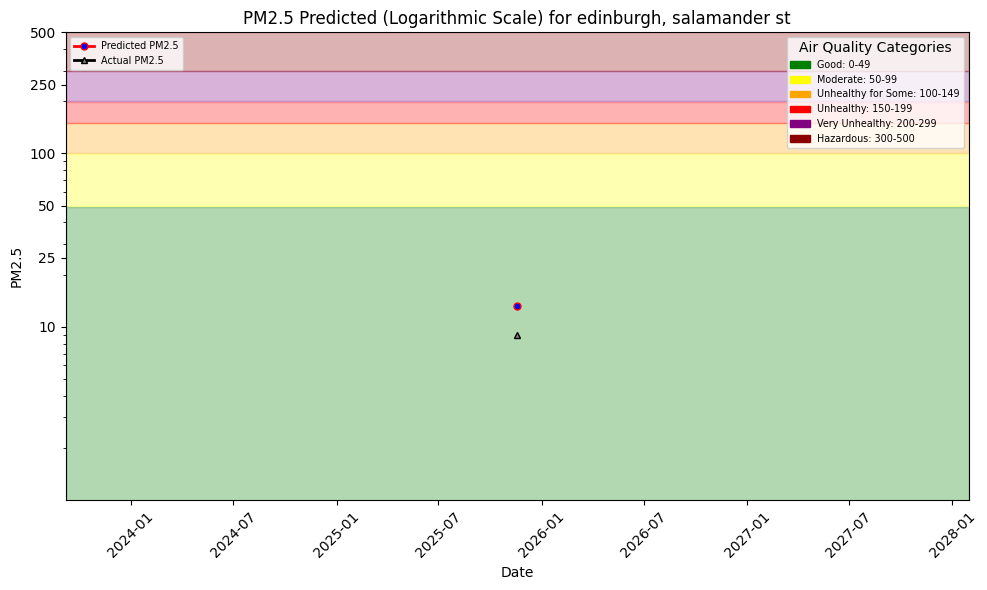

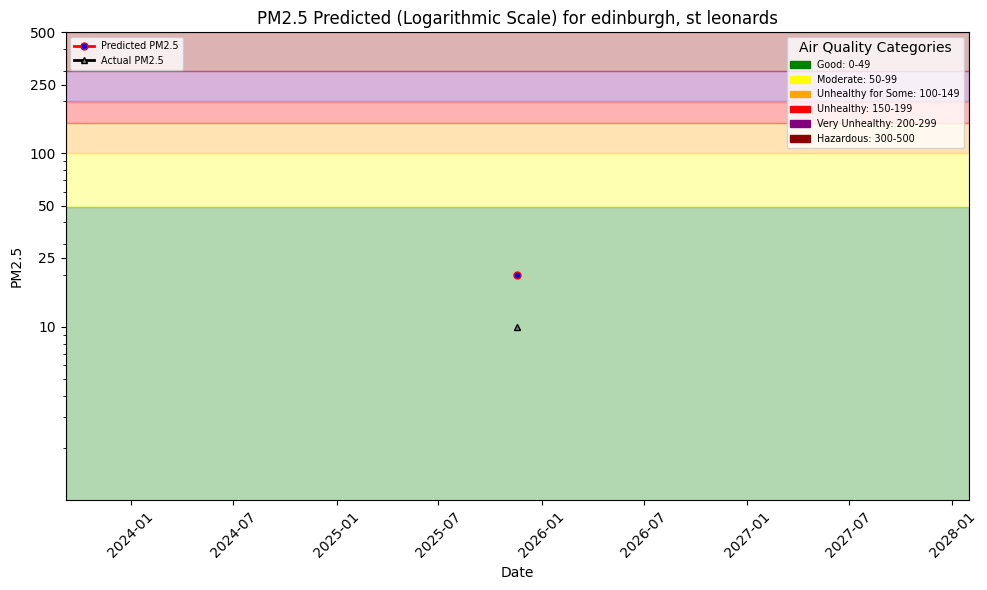

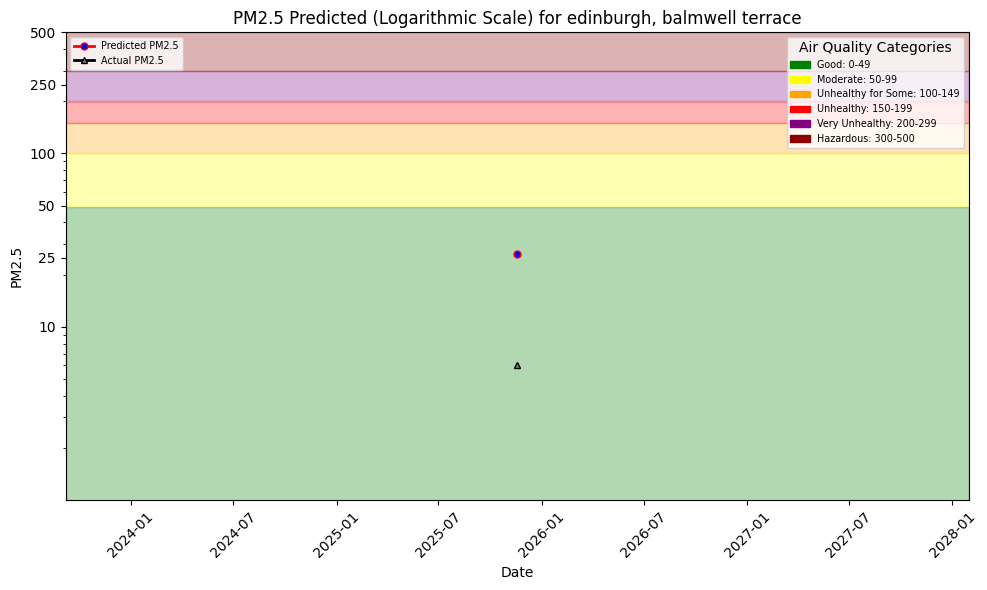

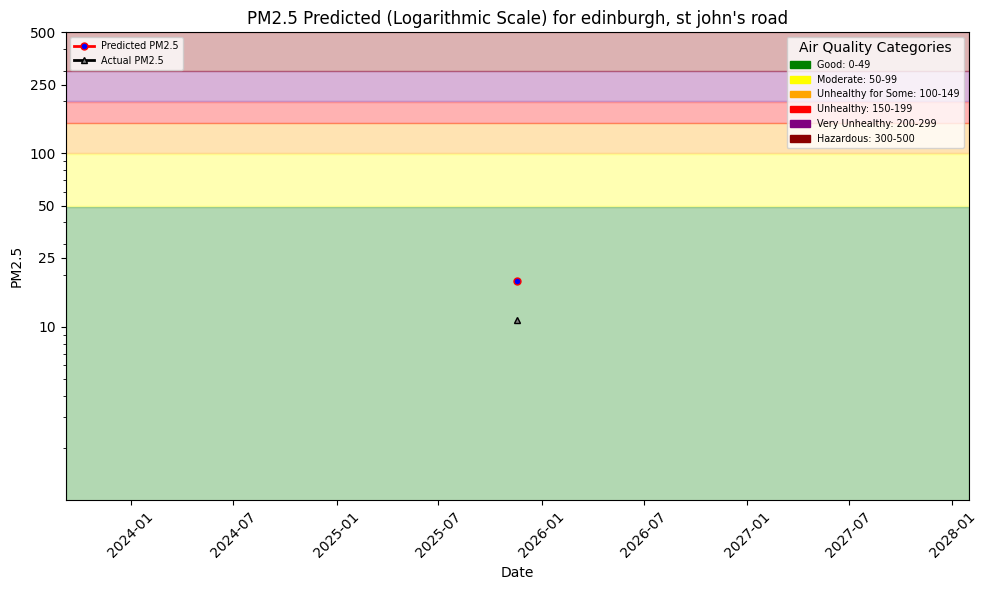

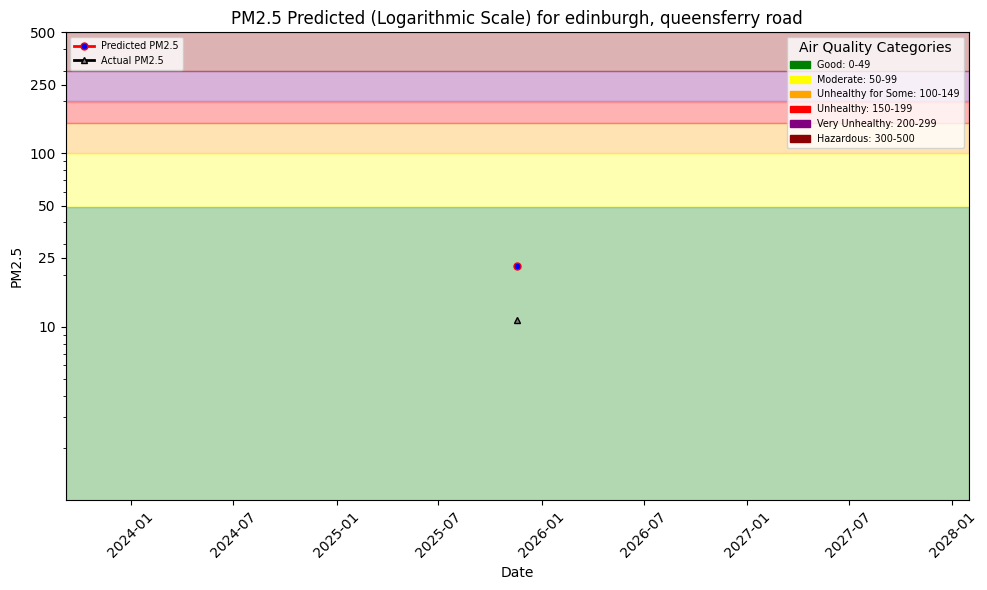

In [21]:
if running_e or running_c:
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

if running_a:
    for h_df in hindcast_dfs:
        street = h_df.iloc[0]['street']
        hindcast_file_path = f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_hindcast_1day{street}.png"
        plt = util.plot_air_quality_forecast(city, street, h_df, hindcast_file_path, hindcast=True)
        plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

if running_e or running_c:
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

if running_a:
    for location in locations:
        street = location['street']
        dataset_api.upload(f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_forecast{street}.png", f"Resources/air_quality_a_{street}/{city}_{street}_{str_today}", overwrite=True)
        dataset_api.upload(f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_hindcast_1day{street}.png", f"Resources/air_quality_a_{street}/{city}_{street}_{str_today}", overwrite=True)


proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/air_q…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272015/settings/fb/path/Resources/airquality


---